# Project: Advanced Lane Finding
## Project Rubric:
    
## Steps:
    1. Camera calibration with 20 input images
    2. Undistort the image
    3. Color and gradient threshold
    4. Perspective Transform and Warp to get top view of the road
    5. Polynomial equation (of order 2) for x = f(y) = Ay^2 + By + C
    6. Calculate radius of the curvature Rcurve = ((1 + (2Ay+B)^2)^3/2)/mod(2A)
    7. Sliding window algorithm to find all the points in the curve
    8. Find continuation of sliding window (search around polynomial) to continue to next frames
    9. Search continuation of points from previous points and fit new polynomials
    10. Draw polygon combining all points (left and right lane points) and fill with green
    11. Do a reverse transform to correct the warped filled polygon back to original image space
    12. Merge the original image with above polygon to show detected lane
    
    Note:
    1. Chessboard size is set to 9x6 for the project. For some images, corners were not visible, I ignored them
    2. The curvature is within few thousand meters +/- for left or right side curve. Looks correct since the project video is from actual road and the initial curve was someware around 1 km (1000 meters).

In [17]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
from moviepy.editor import VideoFileClip
from IPython.display import HTML
%matplotlib inline
nx = 9
ny = 6

In [18]:
def calibrate_camera():
    # Take all 20 images in the camera_cal folder
    objpoints = []
    imgpoints = []
    objp = np.zeros((ny*nx, 3), np.float32)
    objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1, 2)

    # Image 1, 4 and 5 have some corners hidden, hence corners are not found
    # ignoring them for calibration
    for i in os.listdir("./camera_cal"):
        img = mpimg.imread("./camera_cal/" + i)
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
        if ret == True:
            imgpoints.append(corners)
            objpoints.append(objp)

            with_corners = cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
            
            # Only for testing corrected and warped image
            ret, mat, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
            undistorted = cv2.undistort(with_corners, mat, dist, None, mat)
            
            # Save the undistorted frames for debugging
            print("Saving undistorted file to", './test_images_output/' + i)
            cv2.imwrite('./test_images_output/' + i, undistorted)
            
            # Warp the image to fit in the window
            # Four corners of first square
            src = np.float32([corners[0][0], corners[1][0], corners[nx][0], corners[nx+1][0]])

            # c) define 4 destination points dst = np.float32([[,],[,],[,],[,]])
            # Destination shall be a rectangle
            image_offset = 100
            dst = np.float32([[100, 100], [200, 100], [100,200], [200, 200]])
            
            # Get Perspective transform to convert trapezoid to rectangle (like a top view of road)
            M = cv2.getPerspectiveTransform(src, dst)

            # Get warped image to get top view
            warped = cv2.warpPerspective(undistorted, M, (img.shape[1], img.shape[0]), flags=cv2.INTER_LINEAR)
            cv2.imwrite('./test_images_output/warped_' + i, warped)
        else:
            print("********** no corners found")

    # After adding all objpoints (3D space) and image points (2D space), calibrate camera
    ret, mat, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    return mat, dist, rvecs, tvecs

# Calibrate camera using all input images
# For some of the images, corners are hidden and hence not found. Ignored them. 
mat, dist, rvecs, tvecs = calibrate_camera() 

********** no corners found
********** no corners found
Saving undistorted file to ./test_images_output/calibration6.jpg
Saving undistorted file to ./test_images_output/calibration7.jpg
Saving undistorted file to ./test_images_output/calibration3.jpg
Saving undistorted file to ./test_images_output/calibration2.jpg
********** no corners found
Saving undistorted file to ./test_images_output/calibration20.jpg
Saving undistorted file to ./test_images_output/calibration19.jpg
Saving undistorted file to ./test_images_output/calibration18.jpg
Saving undistorted file to ./test_images_output/calibration15.jpg
Saving undistorted file to ./test_images_output/calibration14.jpg
Saving undistorted file to ./test_images_output/calibration16.jpg
Saving undistorted file to ./test_images_output/calibration17.jpg
Saving undistorted file to ./test_images_output/calibration13.jpg
Saving undistorted file to ./test_images_output/calibration12.jpg
Saving undistorted file to ./test_images_output/calibration10.

In [19]:
def color_thresholding(img):
    # Convert to HLS color space and separate the S channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]

    # Grayscale image
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Sobel x
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

    # Threshold x gradient
    thresh_min = 20
    thresh_max = 100
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Threshold color channel
    s_thresh_min = 170
    s_thresh_max = 255
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1
    
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1

    # Undistort using the matrix available from camera calibration
    undistorted = cv2.undistort(combined_binary, mat, dist, None, mat)

    return undistorted

In [20]:
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height

        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window
        # (`right` or `leftx_current`) on their mean position
        if (len(good_left_inds) > minpix):
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if (len(good_right_inds) > minpix):
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty

In [21]:
def fit_polynomial(img_shape, leftx, lefty, rightx, righty):
    ### TO-DO: Fit a second order polynomial to each with np.polyfit() ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty
    
    return left_fit, right_fit, left_fitx, right_fitx, ploty

In [22]:
# This function is used to validate the polynomial by converting it to real-world radius
def measure_curve_radius(left_fit, right_fit, ploty):
    '''
    Calculates the curvature of polynomial functions in meters.
    '''
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    # Calculation of R_curve (radius of curvature)
    left_curve_radius = ((1 + (2*left_fit[0]*y_eval*ym_per_pix + left_fit[1])**2)**(3/2))/(2*left_fit[0])
    right_curve_radius = ((1 + (2*right_fit[0]*y_eval*ym_per_pix + right_fit[1])**2)**(3/2))/(2*right_fit[0]) 
    
    return left_curve_radius, right_curve_radius

In [23]:
def search_around_poly_and_draw(binary_warped, left_fit, right_fit, ploty):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    margin = 150
    
    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Search area within the +/- margin of our polynomial function
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
     
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fit, right_fit, left_fitx, right_fitx, ploty = fit_polynomial(binary_warped.shape, leftx, lefty, rightx, righty)
    
#     # Measure curvature of the polynomial
#     print("curvature x and y:", measure_curve_radius(left_fit, right_fit, ploty))

    # Create an image to draw on and an image to show the selection window
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    out_img = np.dstack((warp_zero, warp_zero, warp_zero))*255
    window_img = np.zeros_like(out_img)
    
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_pts = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    right_line_pts = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((left_line_pts, right_line_pts))
    
    # Fill the lane with green shade
    cv2.fillPoly(window_img, np.int_([pts]), (0, 255, 0))

    # Merge the lane onto the out_img
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    return result

In [24]:
def get_top_view_of_lane(img):
    # Region of interest is a trapezoid in front of vehicle
    offset_bottom = 100
    offset_top = 50
    offset_height = 100

    # Take a trapezoid in the undistorted image and do perspective transform
    src = np.float32([[offset_bottom, img.shape[0]],
                      [img.shape[1]/2-offset_top,img.shape[0]/2+offset_height], 
                      [img.shape[1]/2+offset_top,img.shape[0]/2+offset_height], 
                      [img.shape[1]-offset_bottom, img.shape[0]]])
    # Destination shall be a rectangle
    dst = np.float32([[offset_bottom, img.shape[0]],
                      [offset_bottom, 0], 
                      [img.shape[1]-offset_bottom, 0], 
                      [img.shape[1]-offset_bottom, img.shape[0]]])

    # Get Perspective transform to convert trapezoid to rectangle (like a top view of road)
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    # Get warped image to get top view
    binary_warped = cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]), flags=cv2.INTER_LINEAR)
    return M, Minv, binary_warped

def get_corrected_image(img, M, Minv):
    corrected_image = cv2.warpPerspective(img, Minv, (img.shape[1], img.shape[0]))
    return corrected_image

In [25]:
def process_image(img):
    # Thresholding to create binary image
    processed_image = color_thresholding(img)

    # Get Warped image (top view of lane)
    M, Minv, binary_warped = get_top_view_of_lane(processed_image)
    
    # Find our lane pixels first
    # 1. Find first polynomial by finding histogram of the binary warped image,
    # 2. searching for all peaks to find base,
    # 3. searching for all points around the base with sliding window mechanism 
    # 4. seggregating left points and right points based on the midpoint in the histogram (lane pixels)
    leftx, lefty, rightx, righty = find_lane_pixels(binary_warped)

    # Fit a second order polynomial to each using `np.polyfit`
    left_fit, right_fit, left_fitx, right_fitx, ploty = fit_polynomial(binary_warped.shape, leftx, lefty, rightx, righty)
    
    out_img = search_around_poly_and_draw(binary_warped, left_fit, right_fit, ploty)
    
    # Warp it back to original space
    out_img = get_corrected_image(out_img, M, Minv)

    # Merge the green-shaded lane back to original frame 
    newimage = cv2.addWeighted(img, 1, out_img, 0.5, 0)

    return newimage

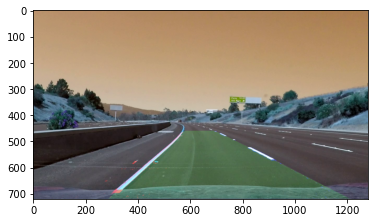

In [33]:
# Debug the logic processing a single frame and then run it for all the frames
input_video = cv2.VideoCapture('project_video.mp4')

ret, frame = input_video.read()

if (ret):
    # Test Color Thresholding
    out_img = np.zeros_like(frame)
    processed_image = color_thresholding(frame)
    out_img = processed_image*255
    cv2.imwrite('./test_images_output/threshold_image.jpg', out_img)
    
    # Get Warped image (top view of lane)
    M, Minv, binary_warped = get_top_view_of_lane(processed_image)
    out_img = binary_warped*255
    cv2.imwrite('./test_images_output/top_view_of_lane.jpg', out_img)
        
    # Test Undistort using camera calibration  
    annotated_image = process_image(frame)
    plt.imshow(annotated_image)
    cv2.imwrite('./test_images_output/annotated_image_with_lane.jpg', annotated_image)
    
    # Convert to HLS color space and separate the S channel
    hls = cv2.cvtColor(frame, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]

    # Grayscale image
    gray = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)

    # Sobel x
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

    # Threshold x gradient
    thresh_min = 20
    thresh_max = 100
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    out_img = sxbinary*255
    cv2.imwrite('./test_images_output/scaled_sobel.jpg', out_img)

    # Threshold color channel
    s_thresh_min = 170
    s_thresh_max = 255
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1
    out_img = s_binary*255
    cv2.imwrite('./test_images_output/s_channel.jpg', out_img)
    
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    out_img = combined_binary*255
    cv2.imwrite('./test_images_output/combined.jpg', out_img)    

In [339]:
# Run the logic for all frames
project_p2_output = 'test_videos_output/project_p2_output.mp4'
clip1 = VideoFileClip("project_video.mp4") #.subclip(0,5)
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(project_p2_output, audio=False)

t:   0%|          | 3/1260 [00:00<01:19, 15.76it/s, now=None]

Moviepy - Building video test_videos_output/project_p2_output.mp4.
Moviepy - Writing video test_videos_output/project_p2_output.mp4



Moviepy - Done !
Moviepy - video ready test_videos_output/project_p2_output.mp4
CPU times: user 8min 12s, sys: 42.4 s, total: 8min 54s
Wall time: 2min 21s


In [340]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(project_p2_output))